In [ ]:
import pandas as pd
import numpy as np
import random
from deap import base, creator, tools, algorithms
import matplotlib.pyplot as plt

from src.config import PROCESSED_DATA_DIR

# ======== 1. Đọc dữ liệu và chuẩn hóa ngành hàng ========
assoc_rules = pd.read_csv(f"{PROCESSED_DATA_DIR}/association_rules.csv")
freq_itemsets = pd.read_csv(f"{PROCESSED_DATA_DIR}/frequent_itemsets.csv")
# Nếu có file high utility itemsets thì mở ra luôn
hui_results = pd.read_csv(f"{PROCESSED_DATA_DIR}/hui_results.csv")


def extract_all_items(*series):
    items = []
    for ser in series:
        items += [item for sublist in ser.apply(eval) for item in sublist]
    return items


ants = assoc_rules["antecedent"].apply(eval)
cons = assoc_rules["consequent"].apply(eval)
all_items_assoc = [
    item for sublist in ants.tolist() + cons.tolist() for item in sublist
]
all_items_freq = extract_all_items(freq_itemsets["items"])
all_items_hui = extract_all_items(hui_results["items"])  # Nếu dùng thêm high utility
all_categories = sorted(
    set(all_items_assoc + all_items_freq)
)  # + all_items_hui nếu muốn

N = len(all_categories)

# ======== 2. Tạo affinity matrix (lift) ========
affinity = pd.DataFrame(0.0, index=all_categories, columns=all_categories, dtype=float)
for _, row in assoc_rules.iterrows():
    ants = eval(row["antecedent"])
    cons = eval(row["consequent"])
    lift = row["lift"]
    for a in ants:
        for c in cons:
            if a in affinity.index and c in affinity.columns:
                affinity.loc[a, c] = max(affinity.loc[a, c], lift)
                affinity.loc[c, a] = max(affinity.loc[c, a], lift)

# ======== 3. TỰ ĐỘNG LỌC FORBIDDEN PAIRS (chỉ cặp lift == 0) ========
forbidden_pairs = set()
for i in range(len(all_categories)):
    for j in range(i + 1, len(all_categories)):
        a, b = all_categories[i], all_categories[j]
        if affinity.loc[a, b] == 0.0:
            forbidden_pairs.add((a, b))
print(f"Total forbidden pairs: {len(forbidden_pairs)} / {(N*(N-1))//2}")


# ======== 4. Hàm fitness với SOFT CONSTRAINT ========
def layout_fitness(layout, affinity_matrix):
    score = 0.0
    for i in range(len(layout) - 1):
        score += affinity_matrix.loc[layout[i], layout[i + 1]]
    return score


def eval_layout(individual):
    layout = [all_categories[i] for i in individual]
    penalty = 0
    for i in range(len(layout) - 1):
        a, b = layout[i], layout[i + 1]
        if (a, b) in forbidden_pairs:
            penalty -= 999  # Thay đổi mức phạt tùy ý (-10, -50, -200...)
    return (layout_fitness(layout, affinity) + penalty,)


# ======== 5. Setup GA/DEAP ========
indices_list = list(range(N))

# Khắc phục lỗi DEAP khi chạy nhiều lần
from deap import creator

for cname in ["FitnessMax", "Individual"]:
    if hasattr(creator, cname):
        delattr(creator, cname)

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("indices", random.sample, indices_list, N)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", eval_layout)
toolbox.register("mate", tools.cxPartialyMatched)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Thông số GA
pop_size = 400
ngen = 300
cxpb = 0.9
mutpb = 0.4

pop = toolbox.population(n=pop_size)
hof = tools.HallOfFame(1)

stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("max", np.max)

pop, log = algorithms.eaSimple(
    pop, toolbox, cxpb, mutpb, ngen, stats=stats, halloffame=hof, verbose=True
)

# ======== 6. Lấy layout tối ưu & xuất ra file ========
best_indices = hof[0]
best_layout = [all_categories[i] for i in best_indices]
print("\n==> Layout ngành hàng tối ưu (top 10):", best_layout[:10], "...")
print("==> Fitness tối ưu:", layout_fitness(best_layout, affinity))

# Đếm số forbidden pairs thực tế trong layout tối ưu
n_forbidden = sum(
    1
    for i in range(len(best_layout) - 1)
    if (best_layout[i], best_layout[i + 1]) in forbidden_pairs
)
print(f"Số forbidden pairs trong layout tối ưu: {n_forbidden}")

pd.DataFrame({"Category": best_layout}).to_csv(
    f"{PROCESSED_DATA_DIR}/optimal_category_layout.csv", index=False
)

# ======== 7. Vẽ quá trình tiến hóa GA ========
max_fit = [gen["max"] for gen in log]
avg_fit = [gen["avg"] for gen in log]
plt.plot(max_fit, label="Max Fitness")
plt.plot(avg_fit, label="Avg Fitness")
plt.legend()
plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Quá trình tiến hóa GA")
plt.show()


import networkx as nx

G = nx.Graph()
for i in range(len(affinity)):
    for j in range(i + 1, len(affinity)):
        a, b = affinity.index[i], affinity.columns[j]
        value = affinity.iloc[i, j]
        if value > 1:  # hoặc đổi ngưỡng
            G.add_edge(a, b, weight=value)

plt.figure(figsize=(14, 10))
pos = nx.spring_layout(G, k=0.4)
edges, weights = zip(*nx.get_edge_attributes(G, "weight").items())
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=500,
    edge_color=weights,
    edge_cmap=plt.cm.coolwarm,
    width=2,
)
plt.title("Cross-sell cluster network (lift > 1)")
plt.show()

import seaborn as sns
import matplotlib.pyplot as plt

# Nếu matrix lớn, lấy top 30 ngành hàng phổ biến nhất (ví dụ theo tổng lift hoặc support)
total_lift = affinity.sum(axis=1) + affinity.sum(axis=0)
top_items = total_lift.sort_values(ascending=False).head(30).index.tolist()
aff_sub = affinity.loc[top_items, top_items]

plt.figure(figsize=(14, 12))
sns.heatmap(aff_sub, annot=False, cmap="coolwarm", square=True)
plt.title("Affinity heatmap (lift) - Top 30 ngành hàng")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

c:\Users\lthnhung\AppData\Local\Programs\Python\Python311\Lib\site-packages\tsfresh\__init__.py:12: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources
2025-08-12 11:23:32.110 | INFO     | src.config:<module>:15 - PROJ_ROOT path is: D:\DataLocal\lthnhung\My Documents\GitHub\Retail-Layout-Optimization-with-ML-Metaheuristics
[I 2025-08-12 11:23:32,193] A new study created in memory with name: no-name-56a522e0-1a66-441f-a73f-c2765639088f
c:\Users\lthnhung\AppData\Local\Programs\Python\Python311\Lib\site-packages\optuna\distributions.py:702: UserWarning: The distribution is specified by [120, 500] and step=40, but the range is not divisible by `step`. It will be replaced by [120, 480].
  warnings.warn(
[I 2025-08-12 11:23:36,241] Trial 0 finished with value: 13.098823903467213 and

Best params: {'lift_threshold': 1.2634538277080332, 'w_lift': 0.6984126321133827, 'w_conf': 0.2966621636038555, 'w_margin': 0.3333140400006668, 'gamma': 3.175948164954618, 'w_aff': 1.9694697495218436, 'w_pair': 0.007769696010490058, 'w_entr': 1.4988150763397146, 'gamma_support': 1.1714268039147793, 'pair_threshold': 0.5538695491109077, 'pop_size': 280, 'elite_ratio': 0.07907461849999958, 'penalty': 20}
Best layout (from Optuna): ['Mat ong', 'San pham thong cau, cong', 'SP ve sinh, tay rua, nrc', 'Sua cac loai', 'Dung cu phuc vu SK&SD', 'Do dung nau an, uong', 'Tau hu cac loai', 'Thit dong lanh', 'San pham che bien d.lanh', 'Cha gio', 'Tru mat khac (FLAN)', 'Kem cac loai', 'Rau,cu,trai cay dong lanh', 'Hai san dong lanh', 'Com, xoi dong lanh', 'Com, gao, nep cac loai', 'Giay ve sinh', 'San pham ve sinh', 'San pham cham soc co the', 'SPham cham soc rang mieng', 'San pham cham soc mat', 'San pham cham soc toc', 'San pham cham soc SK baby', 'HPham va dung cu cao rau', 'Banh(tuoi,mi)TS Cap1

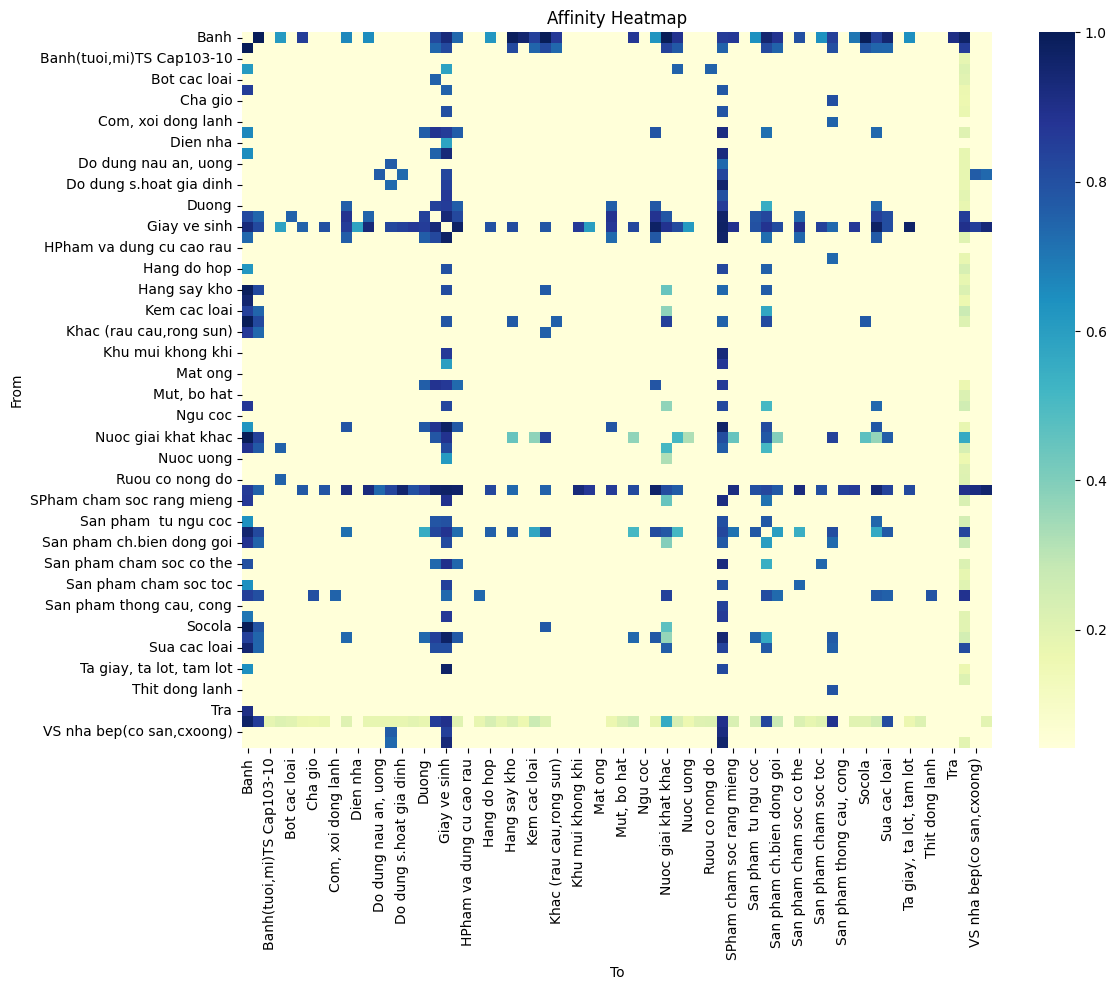

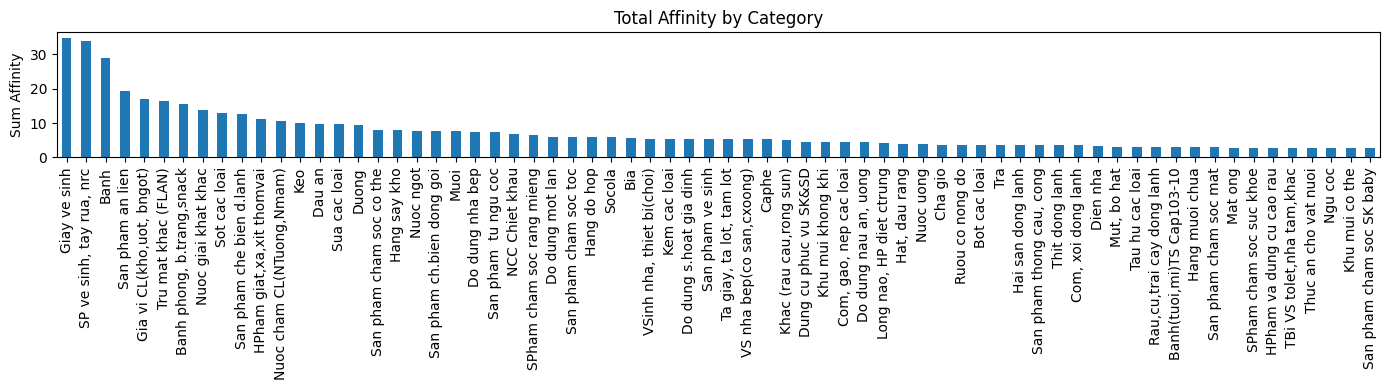

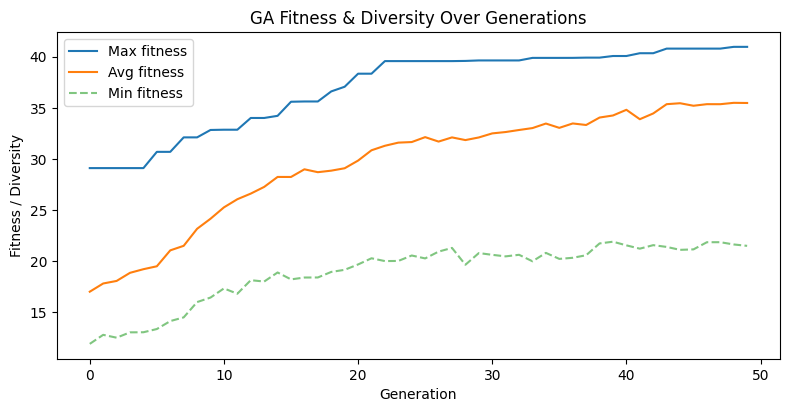

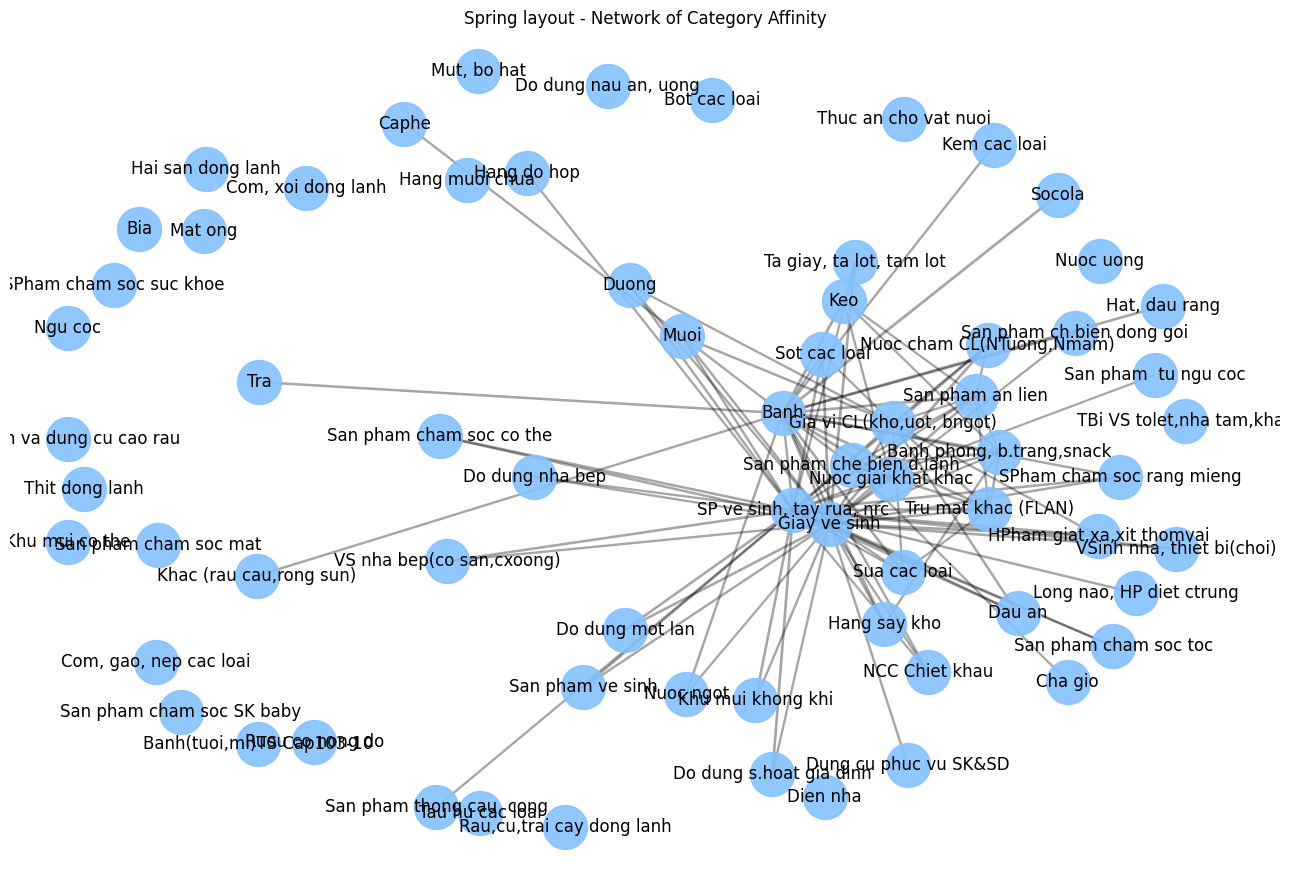